In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from lightgbm.sklearn import LGBMRanker
from experiment_template import *
import os as os

In [111]:
path = "../Data/"
print(os.getcwd())
transactions_train = pd.read_parquet(path + 'transactions_train.parquet')
customers = pd.read_parquet(path + 'customers.parquet')
articles = pd.read_parquet(path + 'articles.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

C:\Users\Arno\Documents\GitHub\ai-project-23-24\ArnoDeKeersmaeker\Research


In [112]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0


In [113]:
# Define periods here
seasons = {
    "Summer": [6,7,8],
    "Autumn": [9,10,11],
    "Winter": [12,1,2],
    "Spring": [3,4,5]
}
# Define the name of the current period (end of September)
current_season = "Autumn"

assert current_season in seasons.keys() # Current period exists
assert set(month_nr for month_nrs in seasons.values() for month_nr in month_nrs) == set(range(1,13)) # All months are in a period
inverted = {month_nr: period for period, month_nrs in seasons.items() for month_nr in month_nrs} # For more efficient lookup

def get_season(month_nr):
    assert month_nr in range(1,13)
    return inverted[month_nr]

transactions_train["t_dat"] = pd.to_datetime(transactions_train["t_dat"])
transactions_train["season"] = transactions_train["t_dat"].dt.month.apply(get_season)

In [114]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,season
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0,Autumn
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0,Autumn
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0,Autumn
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0,Autumn
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0,Autumn


In [115]:
temp1 = transactions_train.groupby(["season", "customer_id"]).size().reset_index(name="count")
temp1

,season,customer_id,count
0,Autumn,25398598941468,1
1,Autumn,28847241659200,26
2,Autumn,41318098387474,6
3,Autumn,43757848922470,10
4,Autumn,77117344919861,71
...,...,...,...
3078769,Winter,18446624797007271432,8
3078770,Winter,18446627193867800506,5
3078771,Winter,18446630855572834764,4
3078772,Winter,18446662237889060501,2


In [116]:
# replace age -1 by average age
average_age = int(customers[customers['age'] != -1]['age'].mean())
customers['age'] = customers['age'].replace(-1, int(average_age))
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645
...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351
1371976,9305341941720086711,-1,-1,0,0,21,80169
1371977,10160427316885688932,1,1,0,1,21,106737
1371978,2551401172826382186,1,1,0,1,18,111894


In [117]:
customers.groupby(["FN"]).size().reset_index(name="count")

,FN,count
0,-1,895050
1,1,476930


In [118]:
# Define customer segments. Defined columns need to exist for customer
segments = {
    # "age" : {float(age): "young" if age < 35 else "middle" for age in range(0,120)},
    # "FN" : {1.0 : "yes_FN", -1.0: "no_FN"},
    "age" : {float(age): "age_young" for age in range(0,120)}
}

for column in segments.keys():
    assert column in customers.columns

segmented_customers = customers.copy()
segment_names = set()

def assign_segment(row):
    # Decide the segment for a single customer
    segment_name = [segments[column][row[column]] for column in segments]
    segment_name = "/".join(segment_name)
    segment_names.add(segment_name)
    return segment_name

# Apply to every customer
segmented_customers['segment'] = customers.apply(assign_segment, axis=1)
segment_names = list(segment_names)

print(segment_names)
segmented_customers

['age_young']


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,segment
0,6883939031699146327,-1,-1,0,0,49,6305,age_young
1,11246327431398957306,-1,-1,0,0,25,33726,age_young
2,18439897732908966680,-1,-1,0,0,24,3247,age_young
3,18352672461570950206,-1,-1,0,0,54,168643,age_young
4,18162778555210377306,1,1,0,1,52,168645,age_young
...,...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351,age_young
1371976,9305341941720086711,-1,-1,0,0,21,80169,age_young
1371977,10160427316885688932,1,1,0,1,21,106737,age_young
1371978,2551401172826382186,1,1,0,1,18,111894,age_young


In [119]:
# We only need id and segment in order to join with transactions
segmented_customers = segmented_customers[['customer_id', 'segment']]

<Axes: xlabel='segment'>

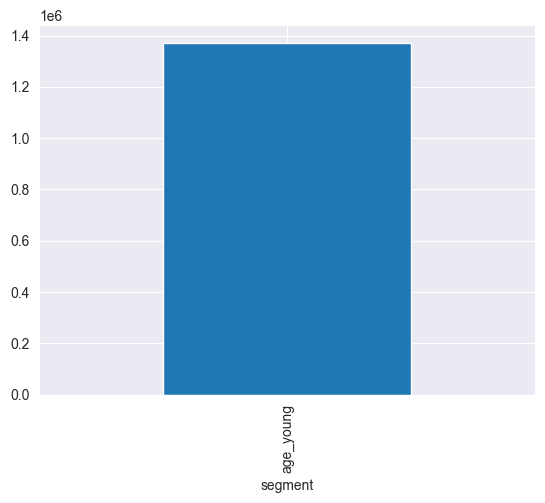

In [120]:
# visualize segment sizes
segmented_customers['segment'].value_counts().plot(kind='bar')

In [121]:
# split the transactions into a dictionary of transactions per segment
transactions_per_segment = {}
transactions = pd.merge(transactions_train, segmented_customers, on="customer_id") # add segment to customers

# split transactions into segments
for segment_name in segment_names: 
    transactions_per_segment[segment_name] = transactions[transactions['segment'] == segment_name]
print(transactions_per_segment.keys())

dict_keys(['age_young'])


In [122]:
next(iter(transactions_per_segment.values()))

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,Autumn,age_young
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,Autumn,age_young
2,2018-10-05,1728846800780188,533518001,0.047441,2,2,Autumn,age_young
3,2018-10-05,1728846800780188,569981006,0.020322,2,2,Autumn,age_young
4,2018-10-05,1728846800780188,669393001,0.067797,2,2,Autumn,age_young
...,...,...,...,...,...,...,...,...
31788319,2020-09-22,18409112236320621348,621381014,0.033881,2,104,Autumn,age_young
31788320,2020-09-22,18417769707947924979,729860001,0.022017,2,104,Autumn,age_young
31788321,2020-09-22,18417769707947924979,889747001,0.022017,2,104,Autumn,age_young
31788322,2020-09-22,18417769707947924979,778517001,0.022017,2,104,Autumn,age_young


In [123]:
# for each segment, find the relative size of the current season compared to all seasons

relative_size_per_segment = {}

# calculated fully separated based on segment
for segment_name, segment in transactions_per_segment.items():
    current_period_size = len(segment[segment['season'] == current_season]) # amount of transactions in current season
    all_periods_size = len(segment) # amount of transactions in all seasons
    relative_size_per_segment[segment_name] = current_period_size / all_periods_size

relative_size_per_segment

{'age_young': 0.24010976483063404}

In [124]:
all_scores = {}
all_scores2 = {}

# features to use for calculating seasonal score
features = ["prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

In [125]:
# for each segment, calculate all scores separately
for segment_name, segment_transactions in transactions_per_segment.items():
    print(f"Current segment: {segment_name}")
    segment_transactions = pd.merge(segment_transactions, articles, on="article_id")
    
    # find the ratio for each feature
    for feature in features:
        seasonal_sales_by_type = segment_transactions.groupby(["season", feature])["article_id"].size().reset_index(name="count")
        assert seasonal_sales_by_type["count"].sum() == len(segment_transactions)
        relative_season_size = 1 / relative_size_per_segment[segment_name] # relative size of the current season compared to all seasons
        
        # Calculate the average sales over all seasons for each feature type (eg average sales of an article that's blue)
        type_average_sales = seasonal_sales_by_type.groupby([feature])["count"].sum().div(relative_season_size).reset_index(name = "avg_all_seasons")
        
        # Only current season is relevant from now on
        seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["season"] == current_season]
        seasonal_sales_by_type = seasonal_sales_by_type.merge(type_average_sales, on=feature)
        seasonal_sales_by_type["season_ratio"] = seasonal_sales_by_type["count"] / seasonal_sales_by_type["avg_all_seasons"]
        
        # # Only keeping the 75% most sold combinations
        # threshold = seasonal_sales_by_type["count"].quantile(0.25)
        # seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["count"] > threshold]
        
        # Creating a ratio look up table
        seasonal_sales_by_type = seasonal_sales_by_type[[feature, "season_ratio"]]
        seasonal_sales_by_type = seasonal_sales_by_type.rename(columns = {feature: "feature"})
        
        # Save together with the other segments
        all_scores[(segment_name, feature)] = seasonal_sales_by_type.set_index("feature").to_dict()["season_ratio"]
print("Done")

Current segment: age_young
Done


In [126]:
# Calculate the season compatibility scores for each article
def create_article_scores(article):
    result = [0 for _ in range(len(segment_names))] # all counters start at 0
    
    # feature by feature, use the segment tables to update the counter of the corresponding segments
    for feature in features:
        feature_value = article[feature] # the actual value of the article for the current feature
        for i, segment_name in enumerate(segment_names):
            score_table = all_scores[(segment_name, feature)] # table that gives the feature score of a segment
            if not feature_value in score_table:
                continue
            result[i] += score_table[feature_value]
    return pd.Series(result)

In [127]:
articles_scores = pd.DataFrame(articles["article_id"]) # create a dataframe with only the article id

# article gets extra columns: for each segment, the score of the article for that segment
articles_scores[segment_names] = articles.apply(create_article_scores, axis=1, result_type="expand")

# normalize the scores
for segment_name in segment_names:
    articles_scores[segment_name] = MinMaxScaler().fit_transform(articles_scores[[segment_name]])

articles_scores

,article_id,age_young
0,108775015,0.395000
1,108775044,0.323106
2,108775051,0.479618
3,110065001,0.362652
4,110065002,0.290758
...,...,...
105537,953450001,0.660903
105538,953763001,0.545185
105539,956217002,0.522801
105540,957375001,0.374840


In [128]:
articles_scores.to_parquet(path + 'articles_edited2.parquet')

In [129]:
def add_features(data):
    columns_to_use = [
        'article_id',
        'product_type_no',
        'graphical_appearance_no',
        'colour_group_code',
        'perceived_colour_value_id',
        'perceived_colour_master_id',
        'department_no',
        'index_code',
        'index_group_no',
        'section_no',
        'garment_group_no',
        'FN',
        'Active',
        'club_member_status',
        'fashion_news_frequency',
        'age',
        'postal_code',
        'ranked_weighted_sales'
    ]

    result = data
    result = pd.merge(result, customers, how='left', on='customer_id')
    result = pd.merge(result, articles, how='left', on='article_id')

    # features from assignment 2 could go here
    # customer_avg_price = transactions_train.groupby('customer_id')['price'].mean().to_frame('preferred_price')
    # result = pd.merge(result, customer_avg_price, how="left", on="customer_id")

    return result[columns_to_use]

In [130]:
def recall(predictions, purchases, k=12):
    # number of correct predictions for the customer / items bought by the customer
    # total recall is the average recall over all customers

    def row_recall(row):
        assert 0 < len(row.purchases)
        correct = 0
        for predicted_item in row.prediction[:k]:
            if predicted_item in row.purchases:
                correct += 1
        return correct / min(len(row.purchases), 12)

    result = pd.merge(purchases, predictions, on="customer_id", how="inner")
    result["recall"] = result.apply(row_recall, axis=1)

    return result.recall.sum() / len(purchases)

In [131]:
segmented_customers

,customer_id,segment
0,6883939031699146327,age_young
1,11246327431398957306,age_young
2,18439897732908966680,age_young
3,18352672461570950206,age_young
4,18162778555210377306,age_young
...,...,...
1371975,7551062398649767985,age_young
1371976,9305341941720086711,age_young
1371977,10160427316885688932,age_young
1371978,2551401172826382186,age_young


In [132]:
### split into training and testing
# one week is used for testing
# a number of weeks leading up to the test week are used to train the ranker
test_week = 105
num_training_weeks = 10
training_weeks = np.arange(test_week-num_training_weeks, test_week)
train_data = transactions_train[transactions_train.week.isin(training_weeks)].reset_index(drop=True)

# add segment of the customer to each transaction
train_data = train_data.merge(segmented_customers, on="customer_id")
train_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment
0,2020-07-15,272412481300040,778064028,0.008458,1,95,Summer,age_young
1,2020-07-15,272412481300040,816592008,0.016932,1,95,Summer,age_young
2,2020-07-15,272412481300040,621381021,0.033881,1,95,Summer,age_young
3,2020-07-15,272412481300040,817477003,0.025407,1,95,Summer,age_young
4,2020-07-15,272412481300040,899088002,0.025407,1,95,Summer,age_young


In [133]:
articles_scores.head()

,article_id,age_young
0,108775015,0.395000
1,108775044,0.323106
2,108775051,0.479618
3,110065001,0.362652
4,110065002,0.290758


In [134]:
### repurchase
# each week is seen as a basket
# the items bought in one basket, will be example for the next basket
# the items bought in the last basket, will be candidates for the test basket
c2weeks = train_data.groupby('customer_id')['week'].unique()
c2weeks2shifted_weeks = {}
for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
candidates_last_purchase = train_data.copy()
weeks = []
for i, (c_id, week) in enumerate(zip(train_data['customer_id'], train_data['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
candidates_last_purchase.week=weeks

sales_counts = train_data.groupby(["week", "article_id", "segment"]).size().reset_index(name="count")
sales_counts = sales_counts.merge(articles_scores, on="article_id")
sales_counts

,week,article_id,segment,count,age_young
0,95,108775015,age_young,2,0.395000
1,96,108775015,age_young,1,0.395000
2,95,108775044,age_young,3,0.323106
3,96,108775044,age_young,8,0.323106
4,97,108775044,age_young,6,0.323106
...,...,...,...,...,...
196875,104,944241001,age_young,35,0.606688
196876,104,945600001,age_young,12,0.698513
196877,104,946475001,age_young,1,0.590696
196878,104,946527001,age_young,4,0.529003


In [135]:
def get_applicable_score(row):
    return row[row["segment"]]
sales_counts = sales_counts.copy()
sales_counts["season_score"] = sales_counts.apply(get_applicable_score, axis=1)
sales_counts

,week,article_id,segment,count,age_young,season_score
0,95,108775015,age_young,2,0.395000,0.395000
1,96,108775015,age_young,1,0.395000,0.395000
2,95,108775044,age_young,3,0.323106,0.323106
3,96,108775044,age_young,8,0.323106,0.323106
4,97,108775044,age_young,6,0.323106,0.323106
...,...,...,...,...,...,...
196875,104,944241001,age_young,35,0.606688,0.606688
196876,104,945600001,age_young,12,0.698513,0.698513
196877,104,946475001,age_young,1,0.590696,0.590696
196878,104,946527001,age_young,4,0.529003,0.529003


In [136]:
sales_counts = sales_counts.drop(columns=segment_names)
sales_counts

,week,article_id,segment,count,season_score
0,95,108775015,age_young,2,0.395000
1,96,108775015,age_young,1,0.395000
2,95,108775044,age_young,3,0.323106
3,96,108775044,age_young,8,0.323106
4,97,108775044,age_young,6,0.323106
...,...,...,...,...,...
196875,104,944241001,age_young,35,0.606688
196876,104,945600001,age_young,12,0.698513
196877,104,946475001,age_young,1,0.590696
196878,104,946527001,age_young,4,0.529003


In [137]:
sales_counts["weighted_sales"] = sales_counts["count"] ** sales_counts["season_score"]
sales_counts

,week,article_id,segment,count,season_score,weighted_sales
0,95,108775015,age_young,2,0.395000,1.314943
1,96,108775015,age_young,1,0.395000,1.000000
2,95,108775044,age_young,3,0.323106,1.426136
3,96,108775044,age_young,8,0.323106,1.957916
4,97,108775044,age_young,6,0.323106,1.784126
...,...,...,...,...,...,...
196875,104,944241001,age_young,35,0.606688,8.645037
196876,104,945600001,age_young,12,0.698513,5.673126
196877,104,946475001,age_young,1,0.590696,1.000000
196878,104,946527001,age_young,4,0.529003,2.082051


In [138]:
sales_counts["ranked_weighted_sales"] = (sales_counts.groupby("week")["weighted_sales"].rank(method="dense", ascending=False).astype("int64"))
sales_counts

,week,article_id,segment,count,season_score,weighted_sales,ranked_weighted_sales
0,95,108775015,age_young,2,0.395000,1.314943,13067
1,96,108775015,age_young,1,0.395000,1.000000,15591
2,95,108775044,age_young,3,0.323106,1.426136,11655
3,96,108775044,age_young,8,0.323106,1.957916,7366
4,97,108775044,age_young,6,0.323106,1.784126,8554
...,...,...,...,...,...,...,...
196875,104,944241001,age_young,35,0.606688,8.645037,749
196876,104,945600001,age_young,12,0.698513,5.673126,1510
196877,104,946475001,age_young,1,0.590696,1.000000,12552
196878,104,946527001,age_young,4,0.529003,2.082051,6006


In [139]:
sales_counts = sales_counts[sales_counts["ranked_weighted_sales"] <= 12]
sales_counts.week += 1
sales_counts = sales_counts.sort_values(by=["week", "article_id", "segment"])

# A list of all customers that bought something during each week
customers_per_week = (train_data.groupby(['week', 'customer_id', 'segment']).head(1).
                      drop(columns=['article_id', 'price', "t_dat", "season", "sales_channel_id"]).drop_duplicates(["week","customer_id"]).copy())
candidates_bestsellers = pd.merge(customers_per_week,sales_counts,on=['week', 'segment'])
candidates_bestsellers_test_week = customers_per_week.drop_duplicates('customer_id').reset_index(drop=True) # all customers who ever bought something
candidates_bestsellers_test_week.week = test_week # join on test week
candidates_bestsellers_test_week = pd.merge(candidates_bestsellers_test_week,sales_counts,on=['week', 'segment'])
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='ranked_weighted_sales', inplace=True)

### combine
d = train_data.copy()
d['purchased'] = True

candidates = pd.concat([
    d, candidates_last_purchase, candidates_bestsellers
])
candidates.purchased.fillna(False, inplace=True)
candidates.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

candidates = pd.merge(
    candidates,
    sales_counts[['week', 'article_id', 'ranked_weighted_sales']],
    on=['week', 'article_id'],
    how='left'
)
candidates = candidates[candidates.week != candidates.week.min()]
candidates["ranked_weighted_sales"].fillna(999, inplace=True)

candidates.sort_values(['week', 'customer_id'], inplace=True)
candidates.reset_index(drop=True, inplace=True)

train_examples = candidates[candidates.week != test_week]
X_train = add_features(train_examples)
Y_train = train_examples['purchased']

ranker = LGBMRanker(
    force_row_wise=True,
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
train_groups = train_examples.groupby(['week', 'customer_id'])['article_id'].count().values
ranker.fit(X_train, Y_train, group=train_groups)
print_importance(ranker, X_train.columns)

### test
# candidates are generated similarly to the examples, only we don't know whether they are purchased
# the same features are extracted and added
# each candidate is scored by the ranker and predictions are generated using the highest scoring candidates
test_candidates = candidates[candidates.week == test_week]

X_test = add_features(test_candidates)
predictions = get_predictions(test_candidates, X_test, ranker, 12)

C:\Users\Arno\AppData\Local\Temp\ipykernel_4212\2106188069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_counts.week += 1


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.162359
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 11395121, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
         ranked_weighted_sales 0.99893
                    article_id 0.00026
                           age 0.00024
               product_type_no 0.00010
              garment_group_no 0.00009
            club_member_status 0.00007
                   postal_code 0.00007
                 department_no 0.00006
       graphical_appearance_no 0.00006
             colour_group_code 0.00005
     perceived_colour_value_id 0.00004
                        Active 0.00002
                index_group_no 0.00002
        fashion_news_frequency 0.00000
                            FN 0.00000
                    section_no 0.00000
                    index_code 0.00000
    perceived_colour_master_id 0.00000


In [140]:
len(predictions)

437365

In [141]:
### evaluate
if test_week < transactions_train.week.max() + 1:
    # get ground truth data for test week
    purchases = get_purchases(transactions_train[transactions_train.week == test_week])

    # fill missing prediction for customers in test set with popular items in last week
    # only for customers in test set because only those are evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, purchases.customer_id, popular)

    # calculate score
    score = mean_average_precision(predictions, purchases, 12)
    print(score)
    score2 = recall(predictions, purchases, 12)
    print(score2)

### submit
else:
    # fill missing predictions for all customers with popular items in last week
    # all customers because we don't know which ones will be evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, customers.customer_id, popular)

    # write submission
    sub = create_submission(predictions, sample_submission)
    sub.to_csv(path + 'sub1.csv.gz', index=False)

In [142]:
sales_counts

,week,article_id,segment,count,season_score,weighted_sales,ranked_weighted_sales
2316,96,372860001,age_young,344,0.452728,14.072488,7
7835,96,547780003,age_young,423,0.494033,19.838077,1
11989,96,579541001,age_young,115,0.593275,16.693984,2
22733,96,678942001,age_young,172,0.521305,14.634976,4
22811,96,678942057,age_young,118,0.558565,14.364182,6
...,...,...,...,...,...,...,...
193404,105,918522001,age_young,609,0.693426,85.295233,4
193407,105,918525001,age_young,342,0.749248,79.179948,5
190339,105,924243001,age_young,852,0.747413,154.969851,1
193505,105,924243002,age_young,635,0.753048,129.009788,2
